## 240823 코드
참고 코드: https://velog.io/@bandi12/텍스트와-음성-데이터를-이용한-한국어-감정-분류-모델-2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request

!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

import librosa
import librosa.display
from IPython.display import Audio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [25]:
txt_data = pd.read_csv("/content/drive/MyDrive/BOAZ_MiniProject1/data/df_emotion.csv", encoding= 'utf-8')
print(f"txt_data 길이: {len(txt_data)}")
print(f"txt_data shape: {txt_data.shape}")

txt_data 길이: 19374
txt_data shape: (19374, 6)


In [26]:
txt_data.head()

,Unnamed: 0,wav_id,text,situation,emotion,emo_num
0,0,5f4141e29dd513131eacee2f,헐! 나 이벤트에 당첨 됐어.,happiness,happiness,1
1,1,5f4141f59dd513131eacee30,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,happiness,happiness,1
2,2,5f4142119dd513131eacee31,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",happiness,happiness,1
3,3,5f4142279dd513131eacee32,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",happiness,happiness,1
4,4,5f3c9ed98a3c1005aa97c4bd,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,neutral,happiness,1


In [27]:
txt_data.rename(columns={'emo_num':'label'}, inplace=True)
new_txt_data = txt_data[['wav_id', 'text', 'label']]
new_txt_data.head()

,wav_id,text,label
0,5f4141e29dd513131eacee2f,헐! 나 이벤트에 당첨 됐어.,1
1,5f4141f59dd513131eacee30,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,1
2,5f4142119dd513131eacee31,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",1
3,5f4142279dd513131eacee32,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",1
4,5f3c9ed98a3c1005aa97c4bd,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,1


#### 음성 데이터 로드

In [23]:
# 데이터 15,000 기준 압축 해제 15분 소요
%cd '/content/drive/MyDrive/BOAZ_MiniProject1'
!zip -FFv '5차년도_2차.zip' --out 'audio_data/5차년도_2차_fixed.zip'
!unzip -qq 'audio_data/5차년도_2차_fixed.zip' -d 'audio_data/'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 Cen   ( 1 6051750786): updating: 5fb9c4f8576e9378b67ac572.wav
 Cen   ( 1 6051750908): updating: 5fb9c5194c55eb78bd7cdfa4.wav
 Cen   ( 1 6051751030): updating: 5fb9c52144697678c497b0f2.wav
 Cen   ( 1 6051751152): updating: 5fb9c546cb503578af9ede87.wav
 Cen   ( 1 6051751274): updating: 5fb9c557cb503578af9ede8a.wav
 Cen   ( 1 6051751396): updating: 5fb9c56e44697678c497b0f4.wav
 Cen   ( 1 6051751518): updating: 5fb9c588cb503578af9ede8c.wav
 Cen   ( 1 6051751640): updating: 5fb9c58c44697678c497b0f7.wav
 Cen   ( 1 6051751762): updating: 5fb9c5964c55eb78bd7cdfa8.wav
 Cen   ( 1 6051751884): updating: 5fb9c59e4c55eb78bd7cdfa9.wav
 Cen   ( 1 6051752006): updating: 5fb9c5be576e9378b67ac578.wav
 Cen   ( 1 6051752128): updating: 5fb9c5cc4c55eb78bd7cdfaf.wav
 Cen   ( 1 6051752250): updating: 5fb9c5ce44697678c497b0f9.wav
 Cen   ( 1 6051752372): updating: 5fb9c5d0cb503578af9ede8f.wav
 Cen   ( 1 6051752494): updating: 5fb9c5dd44697678c497b0fa.wav
 Cen   ( 1 60517526

In [28]:
audio_path = '/content/drive/MyDrive/BOAZ_MiniProject1/audio_data'
wav_list = os.listdir(audio_path)
wav_list_tmp = random.sample(wav_list, 1000) #colab 용량 한계로 1000개만

# wav_list_tmp = wav_list

In [29]:
wav_list_tmp_id = [] #wav 파일명에서 .wav 제외하고 순수한 wav_id를 추출
for i in range(1000):
    wav_list_tmp_id.append(wav_list_tmp[i][:-4])

wav_list_tmp_label, wav_list_tmp_sentence = [], []
for x in wav_list_tmp_id:
  wav_list_tmp_label.append(new_txt_data[new_txt_data['wav_id'] == x]['label'].values[0])
  wav_list_tmp_sentence.append(new_txt_data[new_txt_data['wav_id'] == x]['text'].values[0])

wav_df = pd.DataFrame(
    {'wav_id': wav_list_tmp_id,
     'final_label': wav_list_tmp_label,
     'sentence': wav_list_tmp_sentence
    })

mapping = {
    'neutral': 0,
    'happiness': 1,
    'surprise': 2,
    'sadness': 3,
    'angry': 4,
    'disgust': 5,
    'fear': 6
}
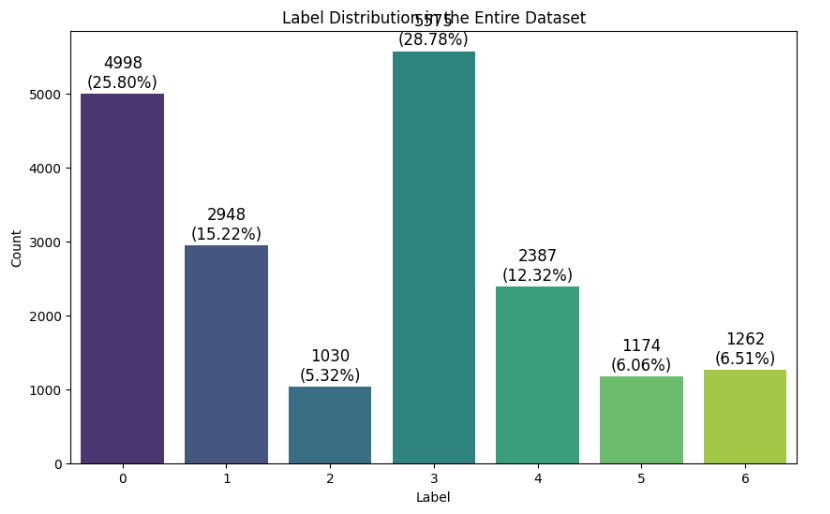

<ipython-input-31-61d308f4f34f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = wav_df['final_label'], palette = "husl",  ax = ax)


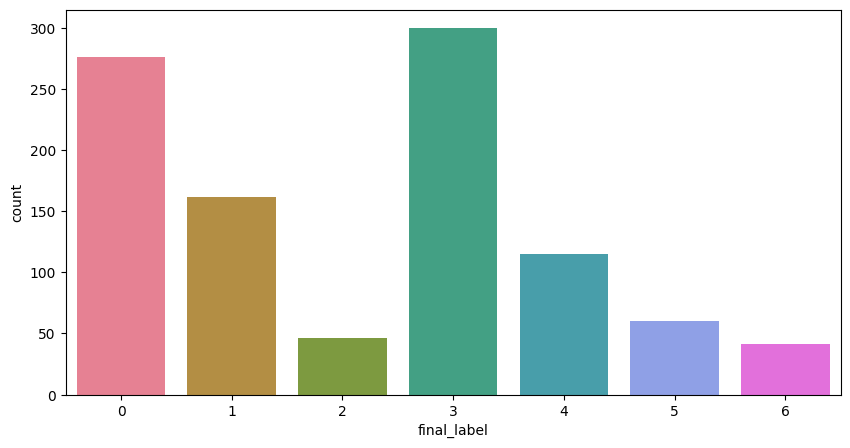

In [31]:
# 라벨 분포 확인
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = wav_df['final_label'], palette = "husl",  ax = ax)
plt.show()

#### (2) 음성 데이터 feature vector 추출

In [32]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [33]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [41]:
import numpy as np
import pandas as pd
import librosa

def noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def extract_features(data, sample_rate):
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
    mfccs_mean = mfccs.mean(axis=1)
    return mfccs_mean

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.0)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.concatenate((result, res2), axis=0)

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.concatenate((result, res3), axis=0)

    return result

X_audio, Y = [], []
for path, label in zip(wav_df['wav_id'], wav_df['final_label']):
    audio_features = get_features(audio_path+'/'+path+'.wav')
    X_audio.append(audio_features)
    Y.append(label)

audio_features_df = pd.DataFrame(X_audio)
final_df = pd.concat([audio_features_df, wav_df[['wav_id', 'final_label', 'sentence']]], axis=1)
final_df.head(3)


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,wav_id,final_label,sentence
0,-692.983093,2.319138,3.000785,26.096342,10.081591,1.448023,-15.784734,0.963499,-11.668512,8.563899,...,-16.212183,-0.757735,-8.936076,8.108759,-4.173273,4.065895,-10.999447,5f6e06b8111dfd48d40fd22f,0,냄새를 방향제로 처리하는 게 가장 좋을 것 같아.
1,-278.249146,121.904488,4.794464,-2.719179,-6.963997,11.205633,-8.099097,7.940930,-28.197205,2.054660,...,-7.151220,3.585419,-30.650652,7.694224,-0.745309,-12.456154,5.368333,5fb893d6576e9378b67ac2eb,3,알겠어. 너도 한번 사용하게 해줄게.
2,-707.698669,8.486257,5.415177,26.322086,3.424736,-2.516698,-15.397957,0.001767,-9.291894,2.594162,...,-16.320028,-2.203383,-9.168161,1.475161,-9.870895,3.448860,-13.135987,5f847176d338b948c4e6942b,5,쓰레기통에 내가 버린 음식물 쓰레기가 상하서 냄새가 나는 거야.


#### 텍스트 embedding vector 추출

In [43]:
import numpy as np
import pandas as pd
import librosa

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# Instead of importing np_utils, just use to_categorical directly
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [44]:
class text_embedding():
  def __init__(self, model_name):
    self.model_name = model_name

  def fit(self, X, y=None):
        return self

  def transform(self, X):
        embedding_model = SentenceTransformer(self.model_name)
        embedding_vec = embedding_model.encode(X['sentence'])
        X_val = np.concatenate((X.drop(['final_label', 'wav_id', 'sentence'], axis = 1), embedding_vec), axis = 1)
        return X_val

#### 모델링

In [50]:
def custom_model(x_train):
  model=Sequential()
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.3))

  # Change the number of units in the final Dense layer to match the number of classes
  model.add(Dense(units=7, activation='softmax'))  # 7 classes instead of 6
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

  #model.summary()
  return model

# Define rlrp outside the function so it's accessible in the global scope
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001) #learning rate 조절

scaler = StandardScaler()
encoder = OneHotEncoder()

# ... (rest of your code remains the same)

In [ ]:

scaler = StandardScaler()
encoder = OneHotEncoder()


pre_trained_models = ['sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
'sentence-transformers/multi-qa-distilbert-cos-v1',
'jhgan/ko-sroberta-multitask',
'all-distilroberta-v1',
'jhgan/ko-sbert-multitask',
'all-MiniLM-L12-v2', 'jhgan/ko-sroberta-sts']


Y = final_df['final_label'].values
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

for i in pre_trained_models:
  txt_embed = text_embedding(model_name = i)
  X = txt_embed.transform(final_df)

  x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)

  x_train = np.expand_dims(x_train, axis=2)
  x_test = np.expand_dims(x_test, axis=2)
  x_train.shape, y_train.shape, x_test.shape, y_test.shape

  model = custom_model(x_train)
  history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  print("Pre-trained Model: ", i)
  print("Test Accuracy: ",test_acc)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.2201 - loss: 1.8667 - val_accuracy: 0.3040 - val_loss: 1.7625 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.2622 - loss: 1.7773 - val_accuracy: 0.2280 - val_loss: 1.7590 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2502 - loss: 1.8158 - val_accuracy: 0.2920 - val_loss: 1.7770 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.2694 - loss: 1.7637 - val_accuracy: 0.2280 - val_loss: 1.7798 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.2995 - loss: 1.7634 - val_accuracy: 0.3160 - val_loss: 1.7565 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.3032 - loss: 1.7205 - val_accuracy: 0.2720 - val_loss: 1.7642 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3073 - loss: 1.7115 - val_accuracy: 0.3560 - va

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/523 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.2558 - loss: 1.8347 - val_accuracy: 0.3040 - val_loss: 1.8129 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.2937 - loss: 1.7406 - val_accuracy: 0.3160 - val_loss: 1.7823 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.2903 - loss: 1.6906 - val_accuracy: 0.3040 - val_loss: 1.8262 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.2457 - loss: 1.7759 - val_accuracy: 0.3200 - val_loss: 1.7872 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2678 - loss: 1.7063 - val_accuracy: 0.3000 - val_loss: 1.7883 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3322 - loss: 1.6884 - val_accuracy: 0.3000 - val_loss: 1.7969 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.2986 - loss: 1.7381 - val_accuracy: 

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.2692 - loss: 1.9543 - val_accuracy: 0.2280 - val_loss: 1.8202 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2344 - loss: 1.7678 - val_accuracy: 0.2680 - val_loss: 1.7742 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.3084 - loss: 1.7449 - val_accuracy: 0.2280 - val_loss: 1.7596 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.2912 - loss: 1.7338 - val_accuracy: 0.3080 - val_loss: 1.7515 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3189 - loss: 1.7188 - val_accuracy: 0.3040 - val_loss: 1.7599 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.2933 - loss: 1.7278 - val_accuracy: 0.2280 - val_loss: 1.7746 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.2789 - loss: 1.7517 - val_accuracy: 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.2601 - loss: 1.9057 - val_accuracy: 0.2280 - val_loss: 1.8873 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.2706 - loss: 1.8053 - val_accuracy: 0.3040 - val_loss: 1.7758 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.3061 - loss: 1.7434 - val_accuracy: 0.2320 - val_loss: 1.7906 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.2885 - loss: 1.7244 - val_accuracy: 0.2520 - val_loss: 1.7928 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.2878 - loss: 1.7802 - val_accuracy: 0.2400 - val_loss: 1.7631 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.2887 - loss: 1.7420 - val_accuracy: 0.2320 - val_loss: 1.7821 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3124 - loss: 1.7308 - val_accuracy: 

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.2126 - loss: 1.9298 - val_accuracy: 0.2280 - val_loss: 1.8347 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2730 - loss: 1.7697 - val_accuracy: 0.2640 - val_loss: 1.7763 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2892 - loss: 1.7751 - val_accuracy: 0.2280 - val_loss: 1.7796 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.3014 - loss: 1.7230 - val_accuracy: 0.3040 - val_loss: 1.7960 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2782 - loss: 1.7298 - val_accuracy: 0.2960 - val_loss: 1.7998 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.2661 - loss: 1.7277 - val_accuracy: 0.2920 - val_loss: 1.7824 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.2861 - loss: 1.7150 - val_accuracy: 